100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]



Training GAN...



GAN epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-3729716992.py:187: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  losses_g.append(float(g_loss))
GAN epoch 5: 100%|██████████| 391/391 [01:10<00:00,  5.56it/s, d_loss=1.39, g_loss=0.693]



Training WGAN...



WGAN epoch 5: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s, d_loss=-2.51, g_loss=-62.8]



Training HINGE...



HINGE epoch 5: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s, d_loss=1.97, g_loss=0.274]


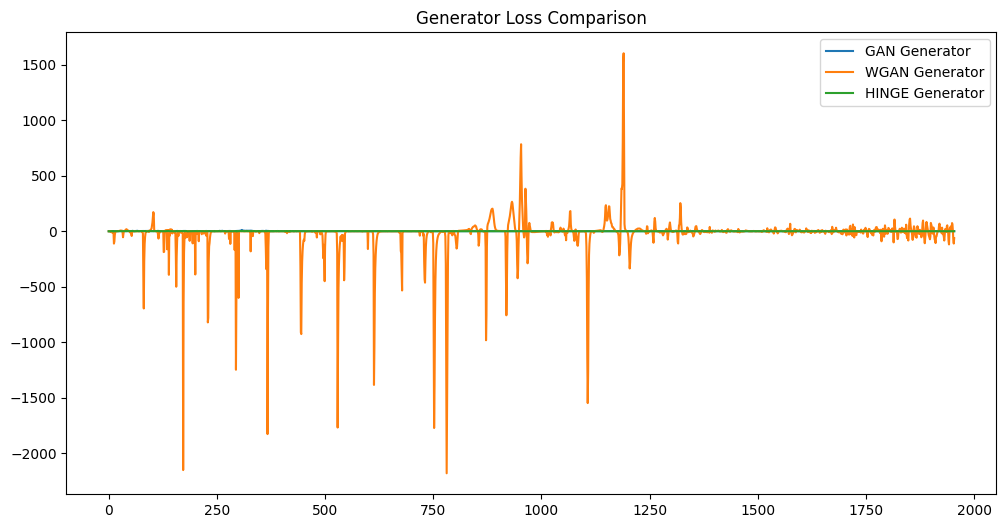

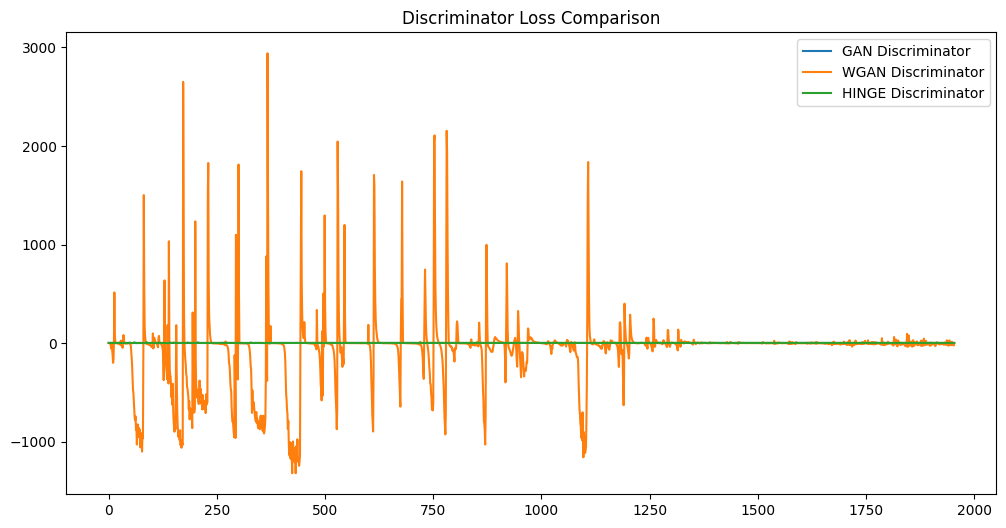

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================================================
# 1. CIFAR-10 Dataloader
# =====================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# =====================================================
# 2. Spectral Norm and ResNet Blocks
# =====================================================
def spectral_norm(module):
    return nn.utils.spectral_norm(module)

class ResBlockGen(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, 3, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, 3, padding=1))
        self.shortcut = spectral_norm(nn.Conv2d(in_channels, out_channels, 1))

    def forward(self, x):
        out = self.upsample(x)
        sc = self.shortcut(out)
        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        return F.relu(out + sc)

class ResBlockDisc(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True):
        super().__init__()
        self.downsample = downsample
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, 3, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, 3, padding=1))
        self.shortcut = spectral_norm(nn.Conv2d(in_channels, out_channels, 1))

    def forward(self, x):
        sc = self.shortcut(x)
        if self.downsample:
            sc = F.avg_pool2d(sc, 2)

        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        if self.downsample:
            out = F.avg_pool2d(out, 2)

        return out + sc

# =====================================================
# 3. Generator and Discriminator Architectures
# =====================================================
latent_dim = 128

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = spectral_norm(nn.Linear(latent_dim, 4*4*256))
        self.block1 = ResBlockGen(256, 256)
        self.block2 = ResBlockGen(256, 128)
        self.block3 = ResBlockGen(128, 64)
        self.conv_out = spectral_norm(nn.Conv2d(64, 3, 3, padding=1))

    def forward(self, z):
        out = self.linear(z).view(-1,256,4,4)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = torch.tanh(self.conv_out(out))
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResBlockDisc(3, 64)
        self.block2 = ResBlockDisc(64, 128)
        self.block3 = ResBlockDisc(128, 256)
        self.linear = spectral_norm(nn.Linear(256*4*4, 1))

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = F.relu(out)
        out = out.view(out.size(0), -1)
        return self.linear(out)

# =====================================================
# 4. Helper Functions
# =====================================================
def sample_noise(n):
    return torch.randn(n, latent_dim).to(device)

def save_samples(model, epoch, folder="samples"):
    os.makedirs(folder, exist_ok=True)
    with torch.no_grad():
        z = sample_noise(64)
        fake = model(z)
        vutils.save_image(fake, f"{folder}/epoch_{epoch}.png", normalize=True)

# =====================================================
# 5. Training Function for Three GAN Variants
# =====================================================
def train_gan(loss_type="gan", epochs=5):
    G = Generator().to(device)
    D = Discriminator().to(device)

    opt_g = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.0, 0.9))
    opt_d = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.0, 0.9))

    losses_g, losses_d = [], []

    for epoch in range(1, epochs+1):
        pbar = tqdm(trainloader, desc=f"{loss_type.upper()} epoch {epoch}")

        for real, _ in pbar:
            real = real.to(device)
            n = real.size(0)

            # -------------------------
            # Train Discriminator
            # -------------------------
            opt_d.zero_grad()

            z = sample_noise(n)
            fake = G(z).detach()

            pred_real = D(real)
            pred_fake = D(fake)

            if loss_type == "gan":
                d_loss = -(torch.log(torch.sigmoid(pred_real)).mean()
                           + torch.log(1 - torch.sigmoid(pred_fake)).mean())

            elif loss_type == "wgan":
                d_loss = -(pred_real.mean() - pred_fake.mean())
                for p in D.parameters():
                    p.data.clamp_(-0.01, 0.01)

            elif loss_type == "hinge":
                d_loss = (F.relu(1 - pred_real).mean() +
                          F.relu(1 + pred_fake).mean())

            d_loss.backward()
            opt_d.step()

            # -------------------------
            # Train Generator
            # -------------------------
            opt_g.zero_grad()
            z = sample_noise(n)
            fake = G(z)
            pred_fake = D(fake)

            if loss_type == "gan":
                g_loss = -torch.log(torch.sigmoid(pred_fake)).mean()

            elif loss_type == "wgan":
                g_loss = -pred_fake.mean()

            elif loss_type == "hinge":
                g_loss = -pred_fake.mean()

            g_loss.backward()
            opt_g.step()

            losses_g.append(float(g_loss))
            losses_d.append(float(d_loss))
            pbar.set_postfix(g_loss=g_loss.item(), d_loss=d_loss.item())

        save_samples(G, epoch, folder=f"samples_{loss_type}")

    return losses_g, losses_d


# =====================================================
# 6. Train All Three GANs
# =====================================================
loss_types = ["gan", "wgan", "hinge"]
results = {}

for loss_type in loss_types:
    print(f"\nTraining {loss_type.upper()}...\n")
    g_loss, d_loss = train_gan(loss_type=loss_type, epochs=5)
    results[loss_type] = {"g": g_loss, "d": d_loss}

# =====================================================
# 7. Plot Loss Curves
# =====================================================
plt.figure(figsize=(12,6))
for loss_type in loss_types:
    plt.plot(results[loss_type]["g"], label=f"{loss_type.upper()} Generator")
plt.legend(); plt.title("Generator Loss Comparison"); plt.savefig("generator_loss.png")

plt.figure(figsize=(12,6))
for loss_type in loss_types:
    plt.plot(results[loss_type]["d"], label=f"{loss_type.upper()} Discriminator")
plt.legend(); plt.title("Discriminator Loss Comparison"); plt.savefig("discriminator_loss.png")


# =====================================================
# 8. Compute FID (Requires pytorch-fid installed)
# =====================================================
# Example:
# !pytorch-fid samples_gan samples_wgan
# (Add your own FID paths here after training)
